In [ ]:
!pip install avalanche-lib

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/134.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.9/971.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.8 MB/s eta 0:00:00
 

In [ ]:
pip install pytorchcv==0.0.67

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: pytorchcv
    Found existing installation: pytorchcv 0.0.71
    Uninstalling pytorchcv-0.0.71:
      Successfully uninstalled pytorchcv-0.0.71


In [ ]:
#from avalanche.benchmarks.datasets import MNIST
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import Module, Linear
from torch.optim import SGD
import pytorchcv
import matplotlib.pyplot as plt
from avalanche.benchmarks.classic import SplitMNIST, PermutedMNIST, SplitCIFAR10, SplitOmniglot, CORe50
from avalanche.benchmarks import nc_benchmark
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
from avalanche.models import SimpleMLP, IcarlNet, SimpleCNN
from avalanche.training.plugins import GenerativeReplayPlugin
from avalanche.training import Naive, EWC, ICaRL
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import accuracy_metrics, Accuracy, forgetting_metrics
from avalanche.evaluation import PluginMetric
from avalanche.evaluation.metrics import Accuracy
from avalanche.evaluation.metric_results import MetricValue
from avalanche.evaluation.metric_utils import get_metric_name


#AMAZON
import re
import string
import collections

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
benchmark = SplitMNIST(n_experiences=5, seed=1, return_task_id=False)

#Modelo generador
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 1 * 28 * 28)
        )

    def forward(self, x):
        return self.fc(x)

    def generate(self, num_samples: int):
        #Random noise
        noise = torch.randn(num_samples, 100)
        #Imagenes fake
        with torch.no_grad():
            fake_images = self(noise).view(num_samples, 1, 28, 28)  #View para pasar de un tensor 2D [num_samples, 784] a uno 4D [num_samples, 1, 28, 28]
        return fake_images

feature_extractor = SimpleMLP(num_classes=benchmark.n_classes)
generator = SimpleGenerator()

optimizer = SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)
generator_optimizer = SGD(generator.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

generator_strategy = Naive(
    model=generator,
    optimizer=generator_optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128
)

generative_replay_plugin = GenerativeReplayPlugin(
    generator_strategy=generator_strategy,
    replay_size=100,
    increasing_replay_size=True,
    #is_weighted_replay=True,
    #weight_replay_loss=0.0001,
    #weight_replay_loss_factor=1.0
)

interactive_logger = InteractiveLogger()

evaluation_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

cl_strategy = Naive(
    model=feature_extractor,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128,
    plugins=[generative_replay_plugin],
    evaluator=evaluation_plugin
)

for experience in benchmark.train_stream:
    print(f"Entrenando en la experiencia {experience.current_experience}")
    cl_strategy.train(experience)
    print("Evaluando en el conjunto de prueba:")
    cl_strategy.eval(benchmark.test_stream)

Entrenando en la experiencia 0
-- >> Start of training phase << --
100%|██████████| 89/89 [00:04<00:00, 21.74it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9481
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9467
100%|██████████| 89/89 [00:03<00:00, 24.49it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9799
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9733
100%|██████████| 89/89 [00:03<00:00, 28.69it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9866
	Top1_Acc_MB/train_phase/train_stream/Task000 = 1.0000
100%|██████████| 89/89 [00:03<00:00, 22.44it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9895
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9733
-- >> End of training phase << --
Evaluando en el conjunto de prueba:
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 15/15 [00:00<00:00, 22.20it/s]
> Eval on experie

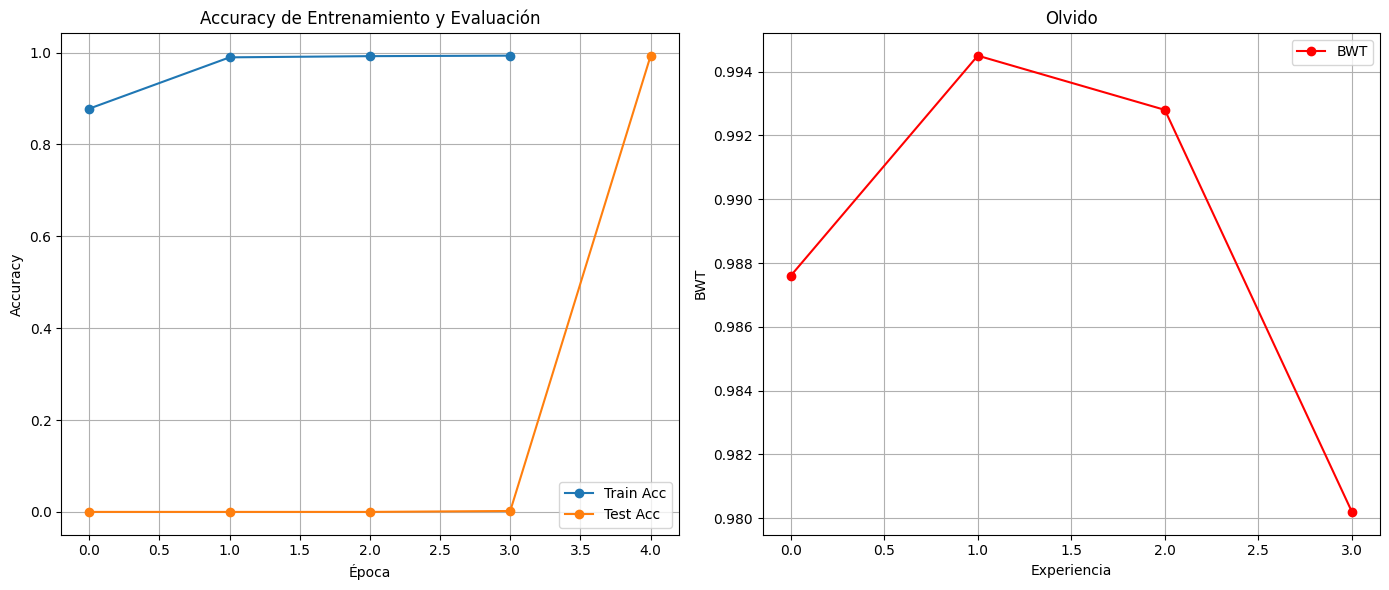

In [ ]:
epochs = [0, 1, 2, 3]
experiences = [0, 1, 2, 3, 4]

train_accuracies = [
    0.8779,
    0.9895,
    0.9921,
    0.9932
]

eval_accuracies = [
    0,
    0,
    0,
    0.0020,
    0.9925
]

forgetting = [
    0.9876,
    0.9945,
    0.9928,
    0.9802,
]

#Accuracy de entrenamiento y evaluación
plt.figure(figsize=(14, 6))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(experiences, eval_accuracies, label='Test Acc', marker='o')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Evaluación')
plt.legend()
plt.grid()

#Olvido
plt.subplot(1, 2, 2)
plt.plot(experiences[:-1], forgetting, label='BWT', marker='o', color='red')
plt.xlabel('Experiencia')
plt.ylabel('BWT')
plt.title('Olvido')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
benchmark = PermutedMNIST(n_experiences=5, seed=1, return_task_id=False)

#Modelo generador
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 1 * 28 * 28)
        )

    def forward(self, x):
        return self.fc(x)

    def generate(self, num_samples: int):
        #Random noise
        noise = torch.randn(num_samples, 100)
        #Imagenes fake
        with torch.no_grad():
            fake_images = self(noise).view(num_samples, 1, 28, 28)  #View para pasar de un tensor 2D [num_samples, 784] a uno 4D [num_samples, 1, 28, 28]
        return fake_images

feature_extractor = SimpleMLP(num_classes=benchmark.n_classes)
generator = SimpleGenerator()

optimizer = SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)
generator_optimizer = SGD(generator.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

generator_strategy = Naive(
    model=generator,
    optimizer=generator_optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128
)

generative_replay_plugin = GenerativeReplayPlugin(
    generator_strategy=generator_strategy,
    replay_size=100,
    increasing_replay_size=True,
    #is_weighted_replay=True,
    #weight_replay_loss=0.0001,
    #weight_replay_loss_factor=1.0
)

interactive_logger = InteractiveLogger()

evaluation_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

cl_strategy = Naive(
    model=feature_extractor,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128,
    plugins=[generative_replay_plugin],
    evaluator=evaluation_plugin
)

for experience in benchmark.train_stream:
    print(f"Entrenando en la experiencia {experience.current_experience}")
    cl_strategy.train(experience)
    print("Evaluando en el conjunto de prueba:")
    cl_strategy.eval(benchmark.test_stream)

Entrenando en la experiencia 0
-- >> Start of training phase << --
100%|██████████| 469/469 [00:24<00:00, 18.82it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8819
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9062
100%|██████████| 469/469 [00:26<00:00, 17.85it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9463
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9792
100%|██████████| 469/469 [00:22<00:00, 21.02it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9600
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
100%|██████████| 469/469 [00:23<00:00, 20.18it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9653
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.9583
-- >> End of training phase << --
Evaluando en el conjunto de prueba:
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 79/79 [00:03<00:00, 26.18it/s]
> Eval on

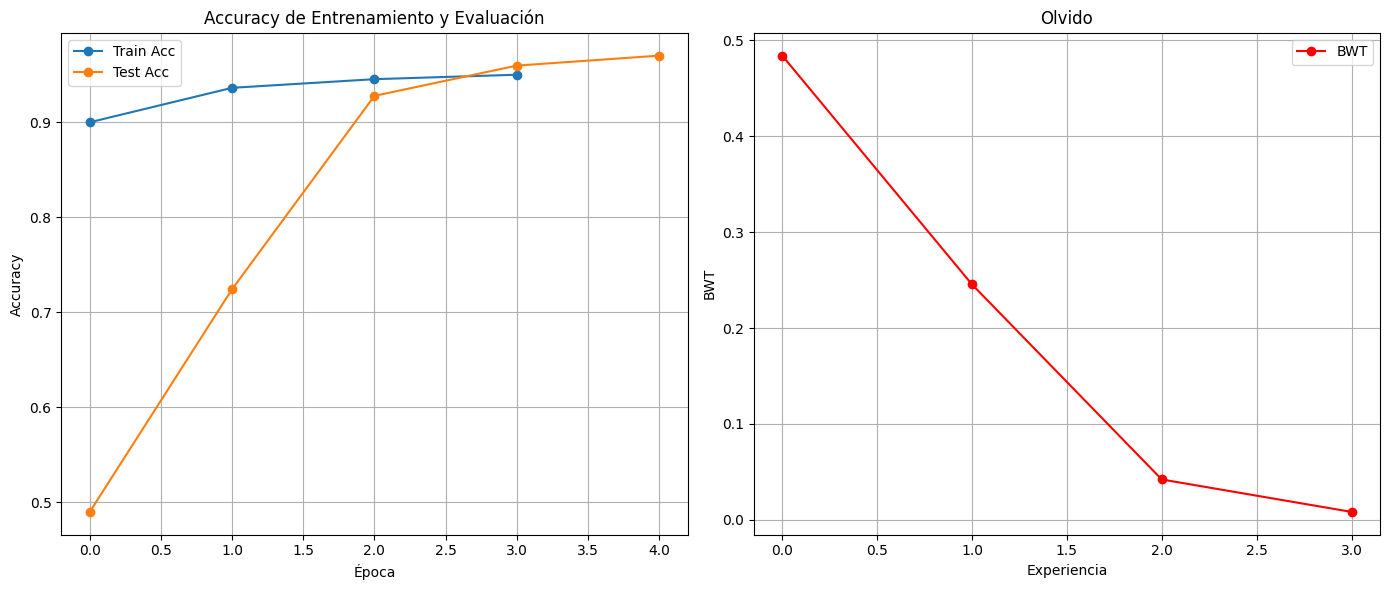

In [ ]:
epochs = [0, 1, 2, 3]
experiences = [0, 1, 2, 3, 4]

train_accuracies = [
    0.9002,
    0.9365,
    0.9456,
    0.9503
]

eval_accuracies = [
    0.4897,
    0.7243,
    0.9280,
    0.9599,
    0.9704
]

# Olvido
forgetting = [
    0.4838,
    0.2454,
    0.0422,
    0.0084,
]

#Accuracy de entrenamiento y evaluación
plt.figure(figsize=(14, 6))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(experiences, eval_accuracies, label='Test Acc', marker='o')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Evaluación')
plt.legend()
plt.grid()

#Olvido
plt.subplot(1, 2, 2)
plt.plot(experiences[:-1], forgetting, label='BWT', marker='o', color='red')
plt.xlabel('Experiencia')
plt.ylabel('BWT')
plt.title('Olvido')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
benchmark = SplitCIFAR10(n_experiences=5, seed=1, return_task_id=False)

class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 32 * 32)
        )

    def forward(self, x):
        return self.fc(x)

    def generate(self, num_samples: int):
        #Random noise
        noise = torch.randn(num_samples, 100)
        #fake images
        with torch.no_grad():
            fake_images = self(noise).view(num_samples, 3, 32, 32)
        return fake_images

generator = SimpleGenerator()

#Modelo de clasificación
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

feature_extractor = SimpleCNN(num_classes=benchmark.n_classes)

optimizer = SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)
generator_optimizer = SGD(generator.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

generator_strategy = Naive(
    model=generator,
    optimizer=generator_optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128
)

generative_replay_plugin = GenerativeReplayPlugin(
    generator_strategy=generator_strategy,
    replay_size=100,
    increasing_replay_size=True,
    #is_weighted_replay=True,
    #weight_replay_loss=0.0001,
    #weight_replay_loss_factor=1.0
)

interactive_logger = InteractiveLogger()

evaluation_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

cl_strategy = Naive(
    model=feature_extractor,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128,
    plugins=[generative_replay_plugin],
    evaluator=evaluation_plugin
)

for experience in benchmark.train_stream:
    print(f"Entrenando en la experiencia {experience.current_experience}")
    cl_strategy.train(experience)
    print("Evaluando en el conjunto de prueba:")
    cl_strategy.eval(benchmark.test_stream)

Files already downloaded and verified
Files already downloaded and verified
Entrenando en la experiencia 0
-- >> Start of training phase << --
100%|██████████| 79/79 [00:26<00:00,  3.00it/s]
Epoch 0 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6694
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8750
100%|██████████| 79/79 [00:23<00:00,  3.32it/s]
Epoch 1 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8199
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.7500
100%|██████████| 79/79 [00:29<00:00,  2.66it/s]
Epoch 2 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8621
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.8125
100%|██████████| 79/79 [00:25<00:00,  3.10it/s]
Epoch 3 ended.
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8693
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.6875
-- >> End of training phase << --
Evaluando en el conjunto de prueba:
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test

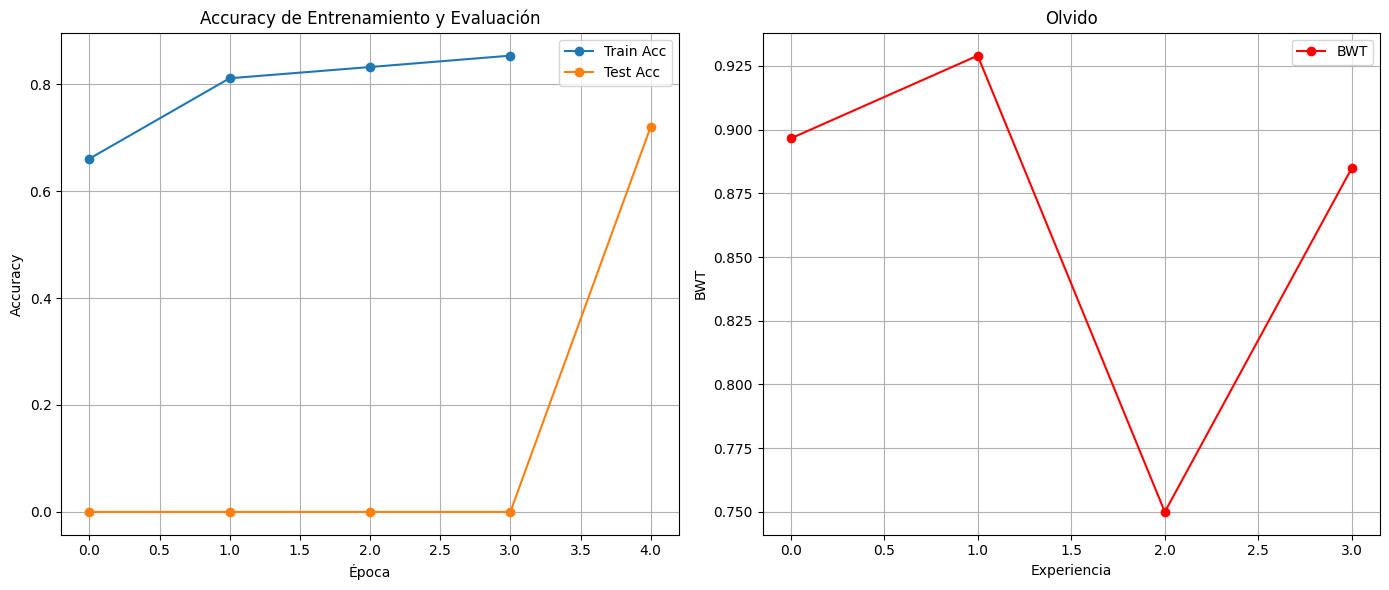

In [ ]:
epochs = [0, 1, 2, 3]
experiences = [0, 1, 2, 3, 4]

train_accuracies = [
    0.6607,
    0.8112,
    0.8322,
    0.8535
]

eval_accuracies = [
    0,
    0,
    0,
    0,
    0.7205
]

# Olvido
forgetting = [
    0.8965,
    0.9290,
    0.7500,
    0.8850,
]

#Accuracy de entrenamiento y evaluación
plt.figure(figsize=(14, 6))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(experiences, eval_accuracies, label='Test Acc', marker='o')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Accuracy de Entrenamiento y Evaluación')
plt.legend()
plt.grid()

#Olvido
plt.subplot(1, 2, 2)
plt.plot(experiences[:-1], forgetting, label='BWT', marker='o', color='red')
plt.xlabel('Experiencia')
plt.ylabel('BWT')
plt.title('Olvido')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
_mu = [0.485, 0.456, 0.406]  #Normalization
_std = [0.229, 0.224, 0.225]

transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=_mu,
        std=_std)
    ])

benchmark = CORe50(scenario='ni', train_transform=transform, eval_transform=transform)

100%|██████████| 5892103007/5892103007 [20:14<00:00, 4851987.58it/s]


Extracting core50_128x128.zip...
Extraction completed!


100%|██████████| 45418248/45418248 [00:00<00:00, 198444655.49it/s]


Extracting batches_filelists.zip...
Extraction completed!


100%|██████████| 13462303/13462303 [00:00<00:00, 143305250.06it/s]

Extracting batches_filelists_NICv2.zip...


Extraction completed!


100%|██████████| 5275590/5275590 [00:00<00:00, 90547761.98it/s]

100%|██████████| 55523548/55523548 [00:00<00:00, 126321149.48it/s]


100%|██████████| 26461948/26461948 [00:00<00:00, 212605962.24it/s]


100%|██████████| 30444/30444 [00:00<00:00, 12925538.11it/s]

Loading labels...


Loading LUP...
Loading labels names...


In [ ]:
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 224 * 224)
        )

    def forward(self, x):
        return self.fc(x)

    def generate(self, num_samples: int):
        noise = torch.randn(num_samples, 100)
        with torch.no_grad():
            fake_images = self(noise).view(num_samples, 3, 224, 224)
        return fake_images

generator = SimpleGenerator()

#Modelo de clasificacion
feature_extractor = SimpleCNN(num_classes=benchmark.n_classes)

optimizer = SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)
generator_optimizer = SGD(generator.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

generator_strategy = Naive(
    model=generator,
    optimizer=generator_optimizer,
    criterion=criterion,
    train_mb_size=128,
    train_epochs=4,
    eval_mb_size=128
)

generative_replay_plugin = GenerativeReplayPlugin(
    generator_strategy=generator_strategy,
    replay_size=100,
    increasing_replay_size=True
)

interactive_logger = InteractiveLogger()

evaluation_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    forgetting_metrics(experience=True, stream=True),
    loggers=[interactive_logger]
)

cl_strategy = Naive(
    model=feature_extractor,
    optimizer=optimizer,
    criterion=criterion,
    train_mb_size=256,
    train_epochs=10,
    eval_mb_size=256,
    plugins=[generative_replay_plugin],
    evaluator=evaluation_plugin
)

for experience in benchmark.train_stream:
    print(f"Entrenando en la experiencia {experience.current_experience}")
    cl_strategy.train(experience)
    print("Evaluando en el conjunto de prueba:")
    cl_strategy.eval(benchmark.test_stream)

NameError: name 'nn' is not defined